# DAT350 Compulsory 1 - Erlend Risvik

## Task (1)

Compute and report the average survival times and average hazards for both groups. Compute also the average hazard ratio for the two groups. Looking at those numbers, what statement can you make regarding survival in each group?

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


# We manually create a list representing each group's survival times.
treatment = [1, 5, 6, 6, 9, 10, 10, 10, 12, 12, 12, 12, 12, 13,
              15, 16, 20, 24, 24, 27, 32, 34, 36, 36, 44]
control = [3, 6, 6, 6, 6, 8, 8, 12, 12, 12, 15, 16, 18, 18, 20,
            22, 24, 28, 28, 28, 30, 30, 33, 42]

# Denote censored as True, False if not. 
censored_treatment = [True, True, False, False, True, False, False, True,
                     False, False, False, False, True, True, True, True,
                     True, False, True, True, False, True, True, True, True]
censored_control = [True, False, False, False, False, False, False, False,
                    False, True, True, True, True, True, False, True, False,
                    True, True, True, False, True, True, False]

print(f"Length of treatments: {len(treatment)}\nLength of control: {len(control)}")
print(f"Length of treatments censored: {len(censored_treatment)}\
      \nLength of control censored: {len(censored_control)}")

# Converting the information into a pandas dataframe in a long format with
# columns "group", "time" and "censored".
df = pd.DataFrame({'group': ['treatment']*len(treatment) + ['control']*len(control),
                    'time': treatment + control, 'censored':
                     censored_treatment + censored_control})
df

Length of treatments: 25
Length of control: 24
Length of treatments censored: 25      
Length of control censored: 24


,group,time,censored
0,treatment,1,True
1,treatment,5,True
2,treatment,6,False
3,treatment,6,False
4,treatment,9,True
5,treatment,10,False
6,treatment,10,False
7,treatment,10,True
8,treatment,12,False
9,treatment,12,False


In [21]:
# Next, we compute the average survival times and average hazards for both groups.

# The average survival time is the average time grouped by treatment/control.
# Note: due to censored patients this will underestimate the true survival time. 
survival_times = df.groupby('group').mean().drop(columns='censored')
survival_treatment = round(survival_times.loc["treatment", 'time'], 3)
survival_control = round(survival_times.loc["control", 'time'], 3)
print(f"The average survival times for\nTreatment: {survival_treatment}\
      \nControl: {survival_control}")

# The average hazard is given by the number of events grouped by treatment/control 
# divided by the number of patients in the group.
# Note that we cannot include the censored patients in this calculation
# because no event is observed. 

hazard = (df[df["censored" ] == False]
          .groupby('group')
          .count()
          .drop(columns='censored'))
hazard_treatment = round(hazard.loc["treatment", 'time'] / sum(treatment), 3)
hazard_control = round(hazard.loc["control", 'time'] / sum(control), 3)
hazard_rate = round(hazard_control/hazard_treatment, 3)

print(f"The average hazard for\nTreatment: {hazard_treatment}\
      \nControl: {hazard_control}")
print(f"The average hazard rate is: {hazard_rate}")

The average survival times for
Treatment: 17.52      
Control: 17.958
The average hazard for
Treatment: 0.023      
Control: 0.028
The average hazard rate is: 1.217


We can say that there is a very little difference between the control group and treatment group. The survival times are roughly the same, though a bit lower for treatment than control. The average hazard rate is slightly lower for treatment than for control. 

**Note** You cannot say that the difference is not significant by looking at the numbers, you have to calculate a statistical significance where you take the censored into account. 

## Task (2)

Show how you compute the estimated survival probability at each failure time and put the results in a table (as discussed in the lecture). It is OK to write your computation on paper and take a photo of it and integrate it into the notebook. 

We prepare the data as required. The formula is explained further down.

In [22]:
# We have to split the dataframes into two and handle both groups individually 
df_treatment = df[df["group"] == "treatment"].reset_index(drop=True)
df_control = df[df["group"] == "control"].reset_index(drop=True)

In [23]:
# We start by sorting the dataframes by time.

df_treatment.sort_values(by=['time'], inplace=True)
df_control.sort_values(by=['time'], inplace=True)
df_treatment.head(), df_control.head()

(       group  time  censored
 0  treatment     1      True
 1  treatment     5      True
 2  treatment     6     False
 3  treatment     6     False
 4  treatment     9      True,
      group  time  censored
 0  control     3      True
 1  control     6     False
 2  control     6     False
 3  control     6     False
 4  control     6     False)

Next, we implement a function to take in the data and return the table suitable for constructing Kaplan Meyer curves.

- The column $t_f$ is the unique time until event/death. $n_f$ is the total amount of people that can fail at each time in $t_f$. $m_f$ is the dead patients and $q_f$ is the censored patients.
- For i $\in 0,.., f$, $n_i$ is given by $n_{i-1}-m_{i-1}-q_{i-1}$.

All of the data required to calculate this is in the dataframe. A short explanation for how the code below works is that it

1. Aggregates the data by time and censored, and then calculates the counts for each time and censor status.

2. Next, it adds a row at the top with the initial values:
    -  $0$ for $t_0$ 
    - False for Censored
    - $0$ for count (no dead patients at start)
    - Note that this is only valid because we have no censored patients at time 0 in either of the groups.
3. m and q is found by separating the censored and non censored patients and calculating their respective counts.
4. The km-table is given by outer joining m and q using "time" column as key and sorting by time. 
5. n is found by subtracting m and q from the previous n value.
6. Optionally, you calculate the survival probability at each time, and return the dataframe.
    - The probability of survival at time $t_i$ is given by
    - $S(t_{(f)})=\prod\limits_{i=1}^f (1-\frac{m_{(i)}}{n_{(i)}})$

In [24]:
def n_i(nf, mf, qf):
    """Function to calculate the number of patients at time t

    Parameters
    ----------
    nf : int
        Number of patients at time t-1
    mf : int
        Number of patients who died at time t-1
    qf : int    
        Number of patients who were censored at time t-1

    Returns
    -------
    int
        Number of patients at time t
    """
    return (nf - mf - qf)

def km_table(df, return_p = False):
    """Function to calculate the Kaplan-Meier table for a given dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with columns "group", "time" and "censored"
    return_p : bool, optional
        Whether to return the table with the survival probability, by default False
    
    Returns
    -------
    pandas.DataFrame
        Kaplan-Meier table, or at least what you need to calculate it.
       """
    
    # Initial number of patients is the total number of patients.
    n = [len(df)]

    # Group by time and censored and count the number of patients in
    # the time point for both censored and not censored.
    agg = (df.groupby(['time', 'censored'])
           .agg(count = ("time", "count"))
           .reset_index())
    

    # Add a row at the top of the dataframe. 
    # Only valid because we have no events or censored patients at time 0. 
    agg = pd.concat([pd.DataFrame([[0, False, 0]], columns=agg.columns), agg], 
                    ignore_index=True)

    # find m and q by grouping by time. Where censored is False is m and True is q.
    m = (agg[agg["censored"] == False]
         .groupby("time")
         .agg(count = ("count", "sum"))
         .reset_index())
    q = (agg[agg["censored"] == True]
         .groupby("time")
         .agg(count = ("count", "sum"))
         .reset_index())

    # Join the m and q as a new dataframe sorted by time. The values m_f and q_f
    # are to be integers
    km_table = (pd.merge(m, q, on="time", how="outer")
                .fillna(0)
                .astype(int)
                .sort_values(by="time")
                .reset_index(drop=True))
    
    # Set correct names
    km_table.columns = ["t_f", "m_f", "q_f"]

    # Add n_f column. 
    for i in range(1, len(km_table)):
        n.append(n_i(n[-1], km_table.loc[i-1, "m_f"], km_table.loc[i-1, "q_f"]))
    km_table["n_f"] = n

    # Arrange so that n_f is between "Time" and "m_f" for easier reading.
    km_table = km_table[["t_f", "n_f", "m_f", "q_f"]]

    if not return_p:
        return km_table

    # Add s_t column
    s_t = [1] # Survival at t=0 is 100%.

    for i in range(1, len(km_table)):
        s_t.append(s_t[-1]*(1-(km_table.loc[i, "m_f"]/km_table.loc[i, "n_f"])))
    km_table["s_t"] = s_t

    return km_table

In [25]:
km_table(df_treatment, return_p=False)


,t_f,n_f,m_f,q_f
0,0,25,0,0
1,1,25,0,1
2,5,24,0,1
3,6,23,2,0
4,9,21,0,1
5,10,20,2,1
6,12,17,4,1
7,13,12,0,1
8,15,11,0,1
9,16,10,0,1


In [26]:
# Including the survival probabilities:
km_table(df_treatment, return_p=True)

,t_f,n_f,m_f,q_f,s_t
0,0,25,0,0,1.000000
1,1,25,0,1,1.000000
2,5,24,0,1,1.000000
3,6,23,2,0,0.913043
4,9,21,0,1,0.913043
5,10,20,2,1,0.821739
6,12,17,4,1,0.628389
7,13,12,0,1,0.628389
8,15,11,0,1,0.628389
9,16,10,0,1,0.628389


Because the exercise asked for how you compute the survival probabilities, it makes sense to delve deeper into the formula

$S(t_{(f)})=\prod\limits_{i=1}^f (1-\frac{m_{(i)}}{n_{(i)}})$

The fraction $\frac{m_i}{n_i}$ is the ratio between the number of people that died at time $t_i$ and the number of people that *can* die at time $t_i$. In simple terms the probability of death. Because probability is mutually exclusive in a probability space, $1-\frac{m_i}{n_i}$ is the opposite. That is, the probability of survival at time $t_i$. 

When you take the product of these probabilities, you get the probability of survival at time $t_f$. This is because each probability $1-\frac{m_i}{n_i}$ is the conditional probability of living at time $t_i$, given that you live up to $t_i$ 




## Task (3)
From your computations in Task 2, draw the Kaplan-Meier survival curves for the control group and the treatment group. In this task you are not allowed to use any survival analysis packages such as lifelines or scikit-survival. It is OK to use matplotlib to plot the curve based on your results. It is also OK to draw the curve by hand on paper, take a photo and integrate it into the Jupyer notebook. In the curve draw a "+" onto the curve to indicate the censored patients. What are the median survival times for each group?


Next, we plot the Kaplan-Meier curve manually. This is done by using the step function to get discrete plots. We also add a + where patients are censored.

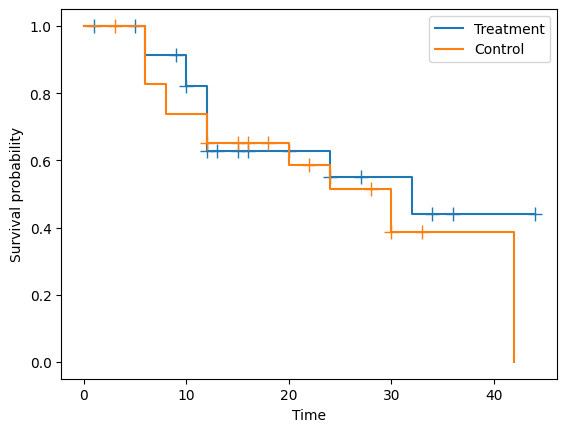

In [27]:
# Create a KM table for each group
km_table_treatment = km_table(df_treatment, return_p=True)
km_table_control = km_table(df_control, return_p=True)

def plot_km(km_table, ax, label, color):
    """Function to plot the Kaplan-Meier curve for a given dataframe.
    Parameters
    ----------
    km_table : pandas.DataFrame
        Kaplan-Meier table
    ax : matplotlib.axes
        axes to plot on
    label : str
        label for the plot
    color : str
        color for the plot
    Returns
    -------
    matplotlib.axes
        axes with the plot
    """
    
    # Use step wise function to get discrete plot
    ax.step(km_table["t_f"], km_table["s_t"], where="post", label=label,
             color=color)
    # Adding markers where censoring occurs. 
    # q_f will have value >= 1 if censored, 0 otherwise.
    ax.plot(km_table["t_f"][km_table["q_f"] >= 1], 
            km_table["s_t"][km_table["q_f"]  >= 1],
             "+", markersize=10, color=color)
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.legend()
    return ax

fig, ax = plt.subplots()
plot_km(km_table_treatment, ax, "Treatment", color = "#1f77b4")
plot_km(km_table_control, ax, "Control", color = "#ff7f0e")
plt.show()


In [28]:
# The median survival times is
median_survival_treatment = km_table_treatment["t_f"][km_table_treatment["s_t"]
                                                       <= 0.5].iloc[0]
median_survival_control = km_table_control["t_f"][km_table_control["s_t"]
                                                   <= 0.5].iloc[0]
print(f"The median survival times for\nTreatment: {median_survival_treatment}\
      \nControl: {median_survival_control}")

The median survival times for
Treatment: 32      
Control: 30


## Task (4)

In the lecture we have used the lifelines package to draw the survival curve. In this task you are required to use the scikit-survival package to fit Kaplan-Meier estimators to the data and plot the curves. Provide also the median survival times computed by the scikit-survival Kaplan-Meier models.

We plot as instructed.

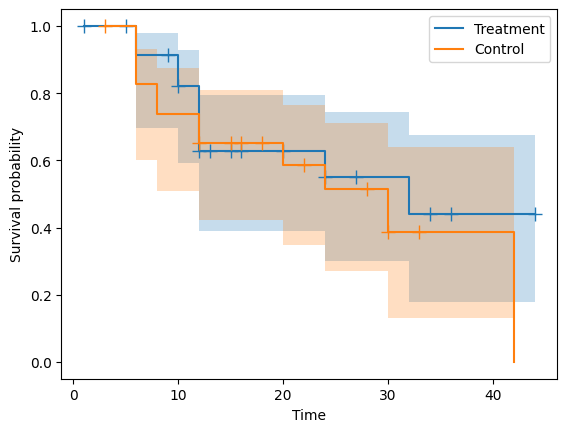

In [29]:
def invert_censor(censored):
    """Function to invert censoring. True is supposed to be observed, not censored
    
    Parameters
    ----------
    censored : list
        List of booleans
        
    Returns
    -------
    list
        List of inverted booleans
    """
    
    return [not item for item in censored]

def plot_km_sk(df, ax, label, color):
    """Function to plot KM using scikit-survival.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with columns "group", "time" and "censored"
    ax : matplotlib.axes
        Axes to plot on
    label : str
        Label for the plot
    color : str
        Color for the plot

    Returns 
    -------
    ax : matplotlib.axes
        Axes with plot
    """

    time, survival_prob, conf_int = kaplan_meier_estimator(
        invert_censor(df["censored"]), df["time"], conf_type="log-log")
    ax.step(time, survival_prob, where="post", label=label, color=color)

    # We need to get the indices where censoring occurs. 
    agg = (df.groupby(['time', 'censored'])
           .agg(count = ("time", "count"))
           .reset_index())
    censored = agg[agg["censored"] == True]["time"].to_list()
    # Match the index
    idx = np.searchsorted(time, censored, side="right") - 1
    
    # Adding markers where censoring occurs.
    ax.plot(time[idx], survival_prob[idx], "+", markersize=10, color=color)
    ax.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.legend()
    return ax

fig, ax = plt.subplots()
plot_km_sk(df_treatment, ax, "Treatment", color = "#1f77b4")
plot_km_sk(df_control, ax, "Control", color =  "#ff7f0e")
plt.show()

In [30]:
# The median survival times are
time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        invert_censor(df_treatment["censored"]), df_treatment["time"])
time_control, survival_prob_control = kaplan_meier_estimator(
        invert_censor(df_control["censored"]), df_control["time"])

median_survival_treatment = time_treatment[survival_prob_treatment <= 0.5][0]
median_survival_control = time_control[survival_prob_control <= 0.5][0]

print(f"The median survival times for\nTreatment: {median_survival_treatment}\
        \nControl: {median_survival_control}")

The median survival times for
Treatment: 32        
Control: 30


The plots are identical except for the confidence intervals. 

The lifelines package is also a lot more convenient for plotting the censored patients.